In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install open3d ruamel.yaml numpy tensorboard plyfile torch==2.1.0+cu118 torchvision==0.16.0 scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.5/420.5 MB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.4/116.4 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 59.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 56.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 108.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 95.6 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstall

In [ ]:
import torch
import torch.nn as nn
import sklearn
import numpy as np
from scipy.cluster.hierarchy import linkage, to_tree
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from plyfile import PlyData, PlyElement

In [ ]:
ply_in = "/content/drive/MyDrive/Splat_models/plant_roberto_example_01.ply" #Gaussian Splat file import
ply_out = "/content/drive/MyDrive/average_plant.ply" #Output file name and location
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
## Read Ply File from Plant:
ply = PlyData.read(ply_in)
#62 properties for Gaussian splat
#311835 points
#19333770 parameters

dim_list = []
for prop in ply.elements[0].properties:
    dim_list.append(torch.tensor(ply.elements[0].data[prop.name]))

tensor = torch.stack(dim_list, dim = 1)
xyz = tensor[:, :3]

tensor = tensor.detach().numpy()
sourceNp = xyz.detach().numpy()

print(sourceNp.shape)
print(tensor.shape)

(311835, 3)
(311835, 62)


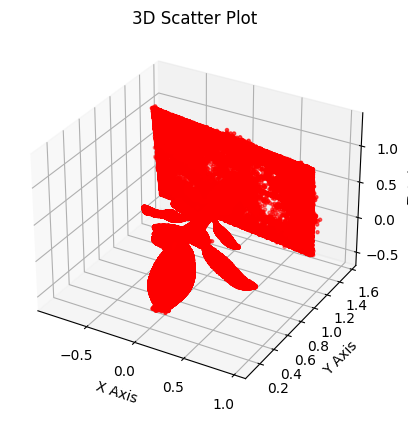

In [ ]:
#Plot Point Cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sourceNp[:,0], sourceNp[:,1], sourceNp[:,2], c='r', marker='.')

# Labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Scatter Plot')

plt.show()

In [ ]:
groupings = []

# VARIABLE A
GROUP_N = 24

#FUTURE WORK: Try new octant func that is based on color (HSV), distance, opacity

def determine_octant(point, reference_point):
    octant = 0
    if point[0] >= reference_point[0]:
        octant |= 1
    if point[1] >= reference_point[1]:
        octant |= 2
    if point[2] >= reference_point[2]:
        octant |= 4
    return octant

# Doesn't have to be in groups of 8 (octant), ideally gets split into more depending on # of leaves
# groups don't even have to be constant one can have 1 child the next can have 100
def find_groups(points):
  mean_point = np.mean(points, axis=0)
  # VARIABLE B
  octants = [[] for _ in range(8)]
  for point in points:
    octant = determine_octant(point[:3], mean_point)
    octants[octant].append(point)

  for octant in octants:
    if len(octant) <= GROUP_N:
      groupings.append(octant)
    else:
      find_groups(octant)

find_groups(tensor)
groupings



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#FUTURE WORK: Try averaging just the low saturation points
def combine(grouping):
  if len(grouping) == 0:
    return None
  return np.mean(grouping, axis=0)


def flatten(groupings):
  flatpak = []
  for group in groupings:
    flat = combine(group)
    if flat is not None:
      flatpak.append(flat)
  return flatpak

flatpak = flatten(groupings)
#plyout = PlyData(flatpak, text=False, byte_order='<')
#plyout.write(ply_out)
flatpak

[array([-4.64528501e-02,  2.65904784e-01, -2.22843409e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  3.11634213e-01,  8.73561084e-01,
        -6.52779460e-01,  8.31493065e-02,  6.95704743e-02,  2.91116908e-03,
         1.41265273e-01, -2.11615469e-02,  2.93505322e-02,  1.14691645e-01,
        -4.30447310e-02, -1.21837016e-02, -9.73894745e-02,  2.75536049e-02,
         3.31578664e-02, -5.74251339e-02, -2.23744940e-02,  1.35754580e-02,
         1.25164790e-02,  1.17988558e-02,  2.77044699e-02,  6.02226853e-02,
         1.49106216e-02,  4.95304130e-02,  3.74605842e-02, -3.84781584e-02,
        -5.64907817e-03, -5.58094047e-02,  1.51096992e-02,  3.31955329e-02,
        -2.38396656e-02, -2.82598734e-02, -1.11724681e-03,  1.54998600e-01,
         1.41052023e-01, -2.45507136e-02,  2.73753464e-01, -5.46879880e-02,
         2.62632594e-02,  2.61175454e-01, -4.31899503e-02, -3.27836201e-02,
        -1.78817943e-01,  9.64389145e-02,  9.81597602e-02, -1.35444358e-01,
        -3.6

In [ ]:
PLY_REF = PlyData.read(ply_in)
ref_dtype = PLY_REF.elements[0].data.dtype

# for np structured arrays they have to be tuples to be interpreted as an N x 1 matrix given a dtype
eee = np.array([tuple(row) for row in flatpak], dtype=ref_dtype)
EEE = PlyElement.describe(eee, 'vertex')
plyout = PlyData([EEE], text=False, byte_order='<')
plyout.write(ply_out)

In [ ]:
## Read Ply File from Output Ply:
ply = PlyData.read(ply_out)

dim_list = []
for prop in ply.elements[0].properties:
    dim_list.append(torch.tensor(ply.elements[0].data[prop.name]))

tensor = torch.stack(dim_list, dim = 1)
xyz = tensor[:, :3]

sourceNp = xyz.detach().numpy()

print(sourceNp.shape)

(45969, 3)


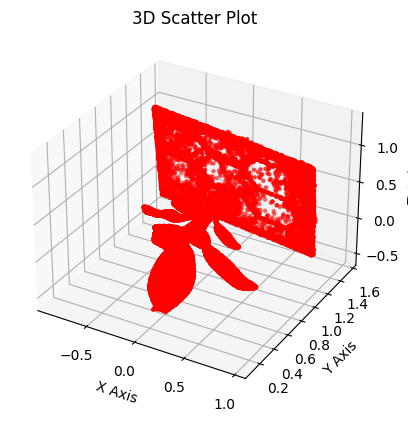

In [ ]:
#Plot Point Cloud
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(sourceNp[:,0], sourceNp[:,1], sourceNp[:,2], c='r', marker='.')

# Labels and title
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
ax.set_title('3D Scatter Plot')

plt.show()

In [ ]:
#Octree Class and parent/child relationship, first iteration

class OctreeNode:
    def __init__(self, points, index=None):
        self.median_point = np.mean(points, axis=0) if points.size > 0 else None
        self.children = []
        self.is_leaf = True
        self.points = points
        self.index = index  # Add index attribute

def build_octree(points, max_points_per_node=8):
    root = OctreeNode(points, index=0)  # Initialize root with index 0
    parent_child_points = []
    next_index = 1  # Start indexing children from 1
    _subdivide_octree(root, parent_child_points, max_points_per_node, next_index)
    return root, parent_child_points

def _subdivide_octree(node, parent_child_relations, max_points_per_node, next_index):
    if node.points.shape[0] <= max_points_per_node:
        return

    node.is_leaf = False
    x_median, y_median, z_median = np.median(node.points, axis=0)
    octants = _get_octants(node.points, x_median, y_median, z_median)

    for octant in octants:
        child_node = OctreeNode(octant, index=next_index)
        node.children.append(child_node)
        next_index += 1
        _subdivide_octree(child_node, parent_child_relations, max_points_per_node, next_index)
        if child_node.is_leaf:
            parent_child_relations.append((node.index, child_node.index))

def _get_octants(points, x_median, y_median, z_median):
    octants = [[] for _ in range(8)]
    for point in points:
        index = 0
        if point[0] >= x_median:
            index |= 1
        if point[1] >= y_median:
            index |= 2
        if point[2] >= z_median:
            index |= 4
        octants[index].append(point)
    return np.array([np.array(octant) for octant in octants], dtype=object)  # Specify dtype=object

# Build the Octree and get parent-child relationships
octree_root, parent_child_relations = build_octree(sourceNp)

In [ ]:
# Convert the relationships to tensors
parent_indices, child_indices = zip(*parent_child_relations)
parent_tensor = torch.tensor(parent_indices, dtype=torch.int32)
child_tensor = torch.tensor(child_indices, dtype=torch.int32)

# Save the tensors to files
torch.save(parent_tensor, parent_out)
torch.save(child_tensor, children_out)

In [ ]:
# Load the tensors
child_tensor = torch.load('plant_children.pt')
parent_tensor = torch.load('plant_parents.pt')

print("Child Tensor Shape:", child_tensor.shape)
print("Parent Tensor Shape:", parent_tensor.shape)

Child Tensor Shape: torch.Size([20980])
Parent Tensor Shape: torch.Size([20980])
